# Precios en tiempos de MiPymes

### Un análisis exploratorio del comportamiento de precios en mercados cubanos

Este notebook analiza la estructura del mercado, los precios de productos alimenticios y las diferencias entre tipos de mercados, utilizando datos de MiPymes y del mercado Yerro.


## Alcance del análisis

El objetivo de este estudio es identificar patrones en la comercialización de productos y en la formación de precios, así como comparar distintos tipos de mercados.

El análisis es exploratorio y se limita a los datos disponibles.


In [1]:
# Con estas 2 lineas recargamos automaticamente todos los archivos afiliados al proyecto, sin necesidad de usar el boton de Restart
%load_ext autoreload
%autoreload 2

from modules.open_json import open_json
import folium
 
mypime = list(open_json("../json/mypime.json"))
geojson = open_json("../json/lha.geojson")
canasta_basica = open_json("../json/canasta_basica.json")
revolico = open_json("../json/revolico.json ")
yerro_m = open_json("./modules/scraping/json_yerro_m/yerro_m.json")


provincia_map = folium.Map(location=(23.133865,-82.3585654))

for i in range(len(mypime)):
    if mypime[i]["ubicacion"]["lat"] is not None and mypime[i]["ubicacion"]["long"] is not None:
        
        folium.Marker(
            location=[mypime[i]["ubicacion"]["lat"], mypime[i]["ubicacion"]["long"]],
            tooltip=f"{mypime[i]["nombre"]}",
            icon=folium.Icon(icon="shopping-cart", color="blue")
        ).add_to(provincia_map)

for j in range(len(yerro_m)):
    if yerro_m[j]["ubicacion"]["lat"] is not None and yerro_m[j]["ubicacion"]["long"] is not None:
             
        folium.Marker(
            location=[yerro_m[j]["ubicacion"]["lat"], yerro_m[j]["ubicacion"]["long"]],
            tooltip=f"{yerro_m[j]["nombre"]}",
            popup= f"<h3>Municipio: {yerro_m[j]["municipio"]}✅  Horario: {yerro_m[j]["horario"]} ⏰</h3>",
            icon=folium.Icon(icon="shopping-cart", color="red")
        ).add_to(provincia_map)
        
        
folium.GeoJson(geojson,
               style_function= lambda x: {
                   "fillColor": "#93FF69",
                   "color": "#08CB00"
               }
               ).add_to(provincia_map)
folium
    
provincia_map

## Composición del mercado

Antes de analizar precios, se examina qué tipo de productos dominan la oferta, con énfasis en la diferencia entre productos nacionales e importados.


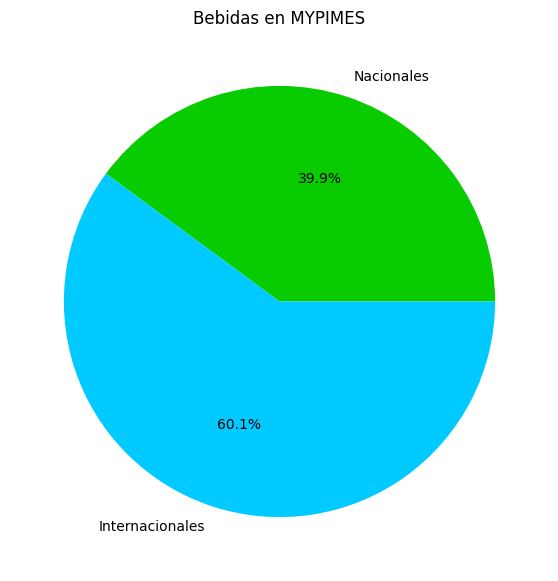

In [2]:
from modules.graphs import bebidas_porciento, yerro_bebida
bebidas_porciento(yerro_bebida(yerro_m))

La mayor presencia de productos importados sugiere una dependencia del mercado externo, lo que puede influir en la estructura de precios observada posteriormente.


## Concentración de marcas

Analizar las marcas más comercializadas permite evaluar el nivel de diversidad y competencia en el mercado.


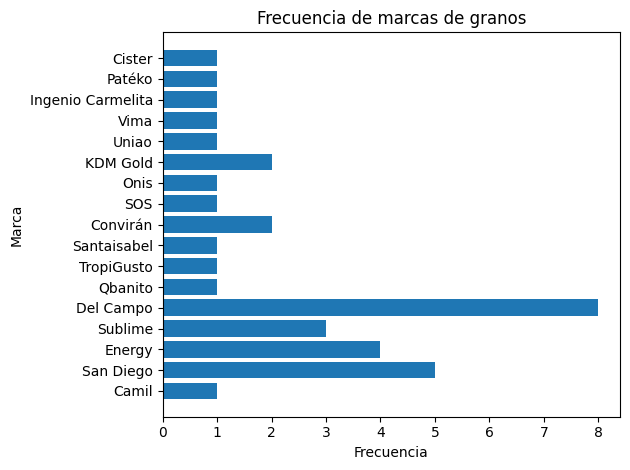

In [ ]:
from modules.graphs import productos_mypimes, marcas
import matplotlib.pyplot as plt

a = productos_mypimes(mypime)
marcas(a)


La concentración en un número reducido de marcas indica un mercado poco diversificado, donde la capacidad de elección del consumidor es limitada.


## Precios promedio de los productos

Una vez identificados los productos más relevantes, se analizan sus precios promedio para caracterizar el comportamiento general del mercado.


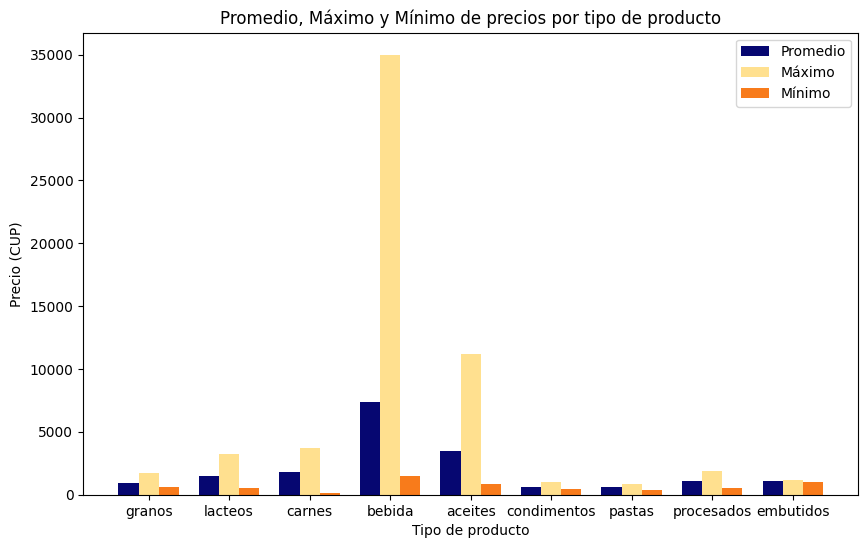

In [ ]:
from modules.graphs import pmm, productos_mypimes
def precios():
    
    tipos_precios = {}
    
    for tienda in productos_mypimes(mypime):
        tipo = tienda["tipo"]
        precio = tienda["precio_cup"]


        if tipo not in tipos_precios:
            tipos_precios[tipo] = []
        tipos_precios[tipo].append(precio)
        
    
    tipos = list(tipos_precios.keys())
    promedios = []
    maximos = []
    minimos = []
    
    for tipo in tipos:
        precios = tipos_precios[tipo]
        promedios.append(sum(precios) / len(precios))
        maximos.append(max(precios))
        minimos.append(min(precios))
    
    pmm(tipos, promedios, maximos, minimos)

precios()

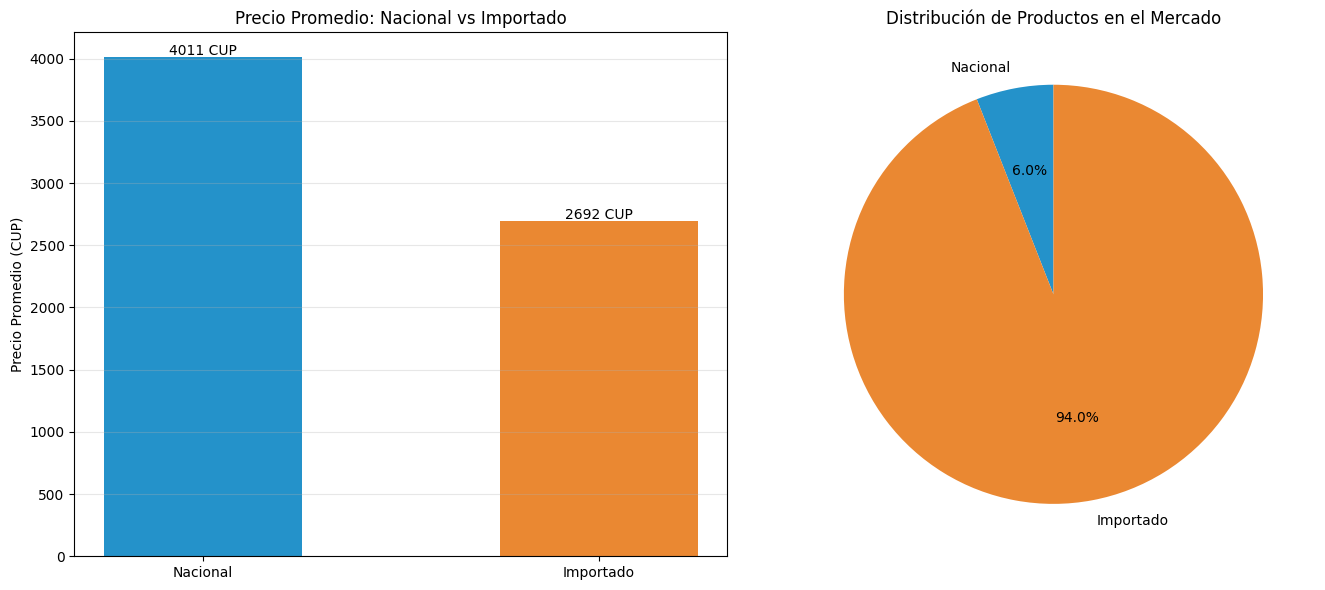

In [ ]:
from modules.graphs import promedio, productos_mypimes
def analizar_nacional_vs_importado():
    
    productos = productos_mypimes(mypime)
    
    nacionales = []
    importados = []
    
    for tienda in productos:
            if "nacional" in tienda:
                if tienda["nacional"] == True:
                    nacionales.append(tienda["precio_cup"])
                else:
                    importados.append(tienda["precio_cup"])
    
    promedio_nacional = promedio(nacionales)
    promedio_importado = promedio(importados)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # barras
    categorias = ["Nacional", "Importado"]
    promedios = [promedio_nacional, promedio_importado]
    colores_barras = ["#2492CA", "#ea8832"]
    
    ax1.bar(categorias, promedios, color=colores_barras, width=0.5)
    ax1.set_ylabel("Precio Promedio (CUP)")
    ax1.set_title("Precio Promedio: Nacional vs Importado")
    ax1.grid(axis="y", alpha=0.3)
    
    for i, v in enumerate(promedios):
        ax1.text(i, v + 20, f"{v:.0f} CUP", ha="center")
    
    # pastel
    cantidades = [len(nacionales), len(importados)]
    ax2.pie(cantidades, labels=categorias, autopct="%1.1f%%", colors=colores_barras, startangle=90)
    ax2.set_title("Distribución de Productos en el Mercado")
    
    plt.tight_layout()
    plt.show()

analizar_nacional_vs_importado()

Los precios promedio muestran diferencias significativas entre productos y mercados, evidenciando la ausencia de una referencia homogénea de precios.


## La canasta básica como punto de quiebre

Más allá de productos individuales, se estima el costo de una canasta mínima basada en gramajes de consumo.

Este cálculo permite evaluar si el salario puede sostener una alimentación básica.


In [ ]:
from modules.graphs import promedio, union, productos_mypimes, productos_yerro, cbasica
from modules.scraping.eltoque import eltoque_scraper
import matplotlib.pyplot as plt
import numpy as np

# tasas_cambio = eltoque_scraper()
cb_nombre_productos, cb_productos = cbasica(canasta_basica)

salario_minimo = 2100  
salario_medio = 4500   

horas_dia = 8
dias_mes = 22
horas_mes = horas_dia * dias_mes  

total_canasta_basica = 0
for i in cb_productos:
    total_canasta_basica += i

productos_m_y = []
for j in union(productos_mypimes(mypime), productos_yerro(yerro_m)):
    productos_m_y.append(
        {
            "nombre": j.get("nombre"),
            "precio": j.get("precio_cup")
        }
    )
  
cb_in_union = []
for cb in cb_nombre_productos:
    for my in productos_m_y:
        if cb is not None and my["nombre"] is not None:
            if cb in my["nombre"]:
                cb_in_union.append(my)

#---------------------------------

arroz = []
frijoles = []
aceite = []
azucar = []
sal = []
leche = []
leche_condensada = []
salchicha = []
huevos = []
picadillo = []
pollo = []
cafe = []
pechuga_pollo = []
spagutti = []
pasta_tomate = []

for k in cb_in_union:
    nombre_lower = k["nombre"].lower()
    
    if "arroz" in nombre_lower:
        arroz.append(k.get("precio"))
        
    if "frijoles" in nombre_lower:
        frijoles.append(k.get("precio"))

    if "aceite" in nombre_lower:
        aceite.append(k.get("precio"))
        
    if "azucar" in nombre_lower or "azúcar" in nombre_lower:
        azucar.append(k.get("precio"))
        
    if "sal" in nombre_lower:
        sal.append(k.get("precio"))
        
    if "leche" in nombre_lower and "condensada" not in nombre_lower:
        leche.append(k.get("precio"))
        
    if "leche condensada" in nombre_lower:
        leche_condensada.append(k.get("precio"))
        
    if "salchicha" in nombre_lower:
        salchicha.append(k.get("precio"))
        
    if "huevo" in nombre_lower:
        huevos.append(k.get("precio"))
        
    if "picadillo" in nombre_lower:
        picadillo.append(k.get("precio"))
        
    if "pollo" in nombre_lower and "pechuga" not in nombre_lower:
        pollo.append(k.get("precio"))
        
    if "cafe" in nombre_lower or "café" in nombre_lower:
        cafe.append(k.get("precio"))

    if "pechuga de pollo" in nombre_lower or "pechuga pollo" in nombre_lower:
        pechuga_pollo.append(k.get("precio"))
        
    if "spaguetti" in nombre_lower or "spaghetti" in nombre_lower:
        spagutti.append(k.get("precio"))
    
    if "pasta de tomate" in nombre_lower:
        pasta_tomate.append(k.get("precio"))

def calcular_promedio(lista):
    return promedio(lista) if lista else 0

p_aceite = calcular_promedio(aceite)
p_arroz = calcular_promedio(arroz)
p_azucar = calcular_promedio(azucar)
p_cafe = calcular_promedio(cafe)
p_spagutti = calcular_promedio(spagutti)
p_frijoles = calcular_promedio(frijoles)
p_huevos = calcular_promedio(huevos)
p_leche = calcular_promedio(leche)
p_leche_condensada = calcular_promedio(leche_condensada)
p_pasta_tomate = calcular_promedio(pasta_tomate)
p_pechuga_pollo = calcular_promedio(pechuga_pollo)
p_picadillo = calcular_promedio(picadillo)
p_pollo = calcular_promedio(pollo)
p_sal = calcular_promedio(sal)
p_salchicha = calcular_promedio(salchicha)

lista_nombre = cb_nombre_productos 
lista_precio = []

for producto in cb_nombre_productos:
    producto_lower = producto.lower()
    
    if "arroz" in producto_lower:
        lista_precio.append(p_arroz)
    elif "frijoles" in producto_lower:
        lista_precio.append(p_frijoles)
    elif "leche" in producto_lower and "condensada" not in producto_lower:
        lista_precio.append(p_leche)
    elif "leche condensada" in producto_lower:
        lista_precio.append(p_leche_condensada)
    elif "aceite" in producto_lower:
        lista_precio.append(p_aceite)
    elif "sal" in producto_lower:
        lista_precio.append(p_sal)
    elif "salchicha" in producto_lower:
        lista_precio.append(p_salchicha)
    elif "huevo" in producto_lower:
        lista_precio.append(p_huevos)
    elif "picadillo" in producto_lower:
        lista_precio.append(p_picadillo)
    elif "pollo" in producto_lower and "pechuga" not in producto_lower:
        lista_precio.append(p_pollo)
    elif "pechuga de pollo" in producto_lower:
        lista_precio.append(p_pechuga_pollo)
    elif "cafe" in producto_lower or "café" in producto_lower:
        lista_precio.append(p_cafe)
    elif "spaguetti" in producto_lower or "spaghetti" in producto_lower:
        lista_precio.append(p_spagutti)
    elif "pasta de tomate" in producto_lower:
        lista_precio.append(p_pasta_tomate)
    elif "azucar" in producto_lower or "azúcar" in producto_lower:
        lista_precio.append(p_azucar)


#comparación de precios canasta básica y mercado
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(cb_nombre_productos))  
width = 0.35                          

bars1 = ax.bar(x - width/2, cb_productos, width, label="Canasta Básica (Precio Oficial)", color="#2ecc71")
bars2 = ax.bar(x + width/2, lista_precio, width, label="Mercado (Precio Promedio)", color="#e74c3c")

ax.set_xlabel("Productos")
ax.set_ylabel("Precio (CUP)")
ax.set_title("Comparación de Precios: Canasta Básica vs Mercado")
ax.set_xticks(x)
ax.set_xticklabels(cb_nombre_productos, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0: 
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f"{height:.0f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ESTADÍSTICAS DE COMPARACIÓN")
print("="*50)
for i, producto in enumerate(cb_nombre_productos):
    precio_oficial = cb_productos[i]
    precio_mercado = lista_precio[i]
    diferencia = precio_mercado - precio_oficial
    porcentaje = (diferencia / precio_oficial * 100) if precio_oficial > 0 else 0
    
    print(f"{producto}:")
    print(f"  Oficial: {precio_oficial:.0f} CUP")
    print(f"  Mercado: {precio_mercado:.0f} CUP")
    print(f"  Diferencia: {diferencia:+.0f} CUP ")
    print()


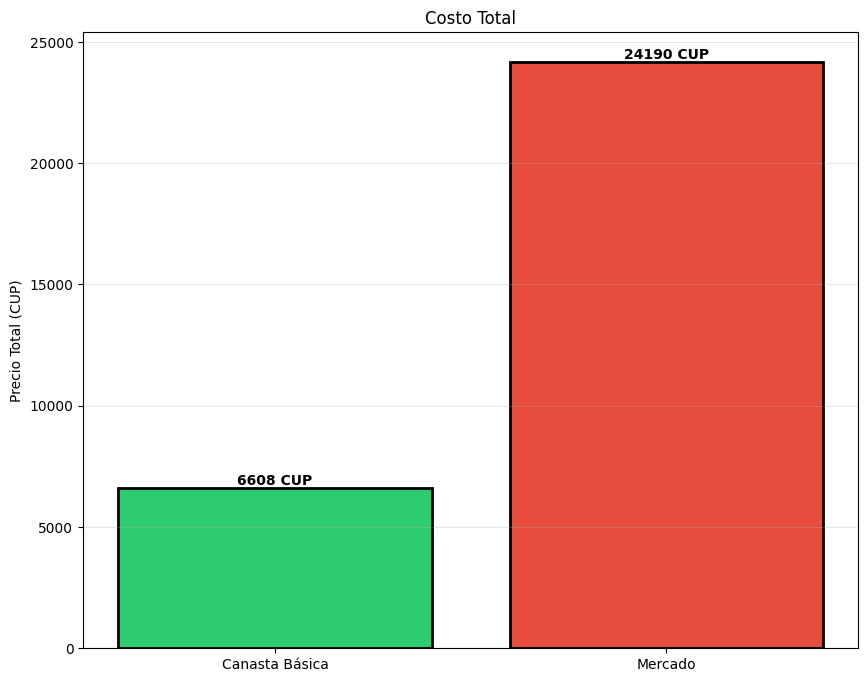

In [ ]:
# total canasta básica vs mercado
total_mercado = 0
for i in lista_precio:
    total_mercado += i
    
fig, ax = plt.subplots(figsize=(10, 8))
totales = [total_canasta_basica, total_mercado]
colores = ["#2ecc71", "#e74c3c"]
bars = ax.bar(["Canasta Básica", "Mercado"], totales, color=colores, edgecolor="black", linewidth=2)
ax.set_ylabel("Precio Total (CUP)")
ax.set_title("Costo Total")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")



El costo de la canasta básica representa una proporción significativa del ingreso mensual.

Esto indica que el salario promedio no permite sostener una alimentación básica sin comprometer prácticamente todo el ingreso.


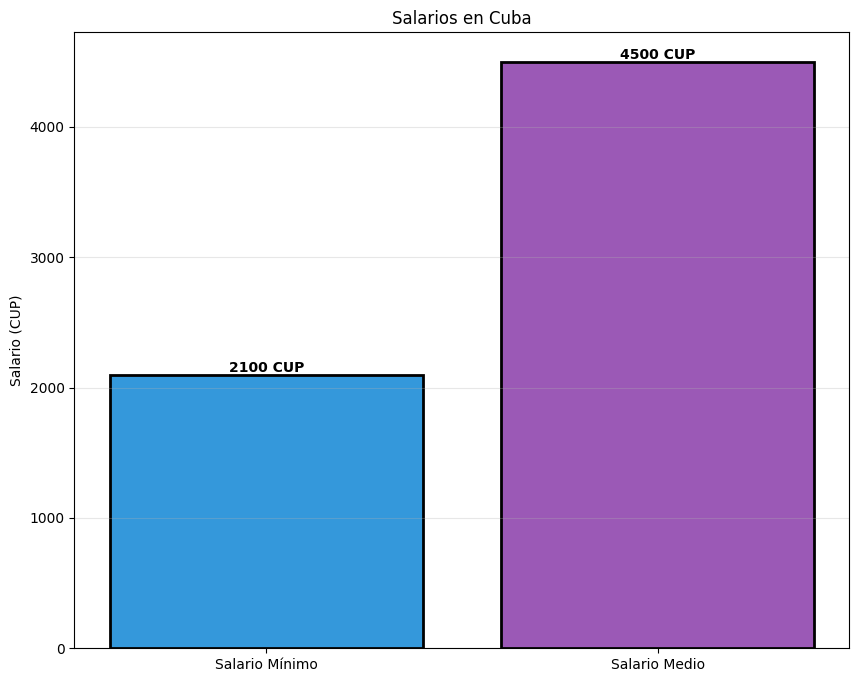

In [ ]:
# salarios
fig, ax = plt.subplots(figsize=(10, 8))
salarios = [salario_minimo, salario_medio]
bars = ax.bar(["Salario Mínimo", "Salario Medio"], salarios, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.set_ylabel("Salario (CUP)")
ax.set_title("Salarios en Cuba")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")




Cada barra es la cantidad TOTAL de horas que una persona con salario mínimo o medio debe trabajar en el mes para poder pagar la canasta básica completa.

No es “cuánto por día”, sino “cuántas horas/días de trabajo necesitas en total para cubrir esa canasta con ese salario”.


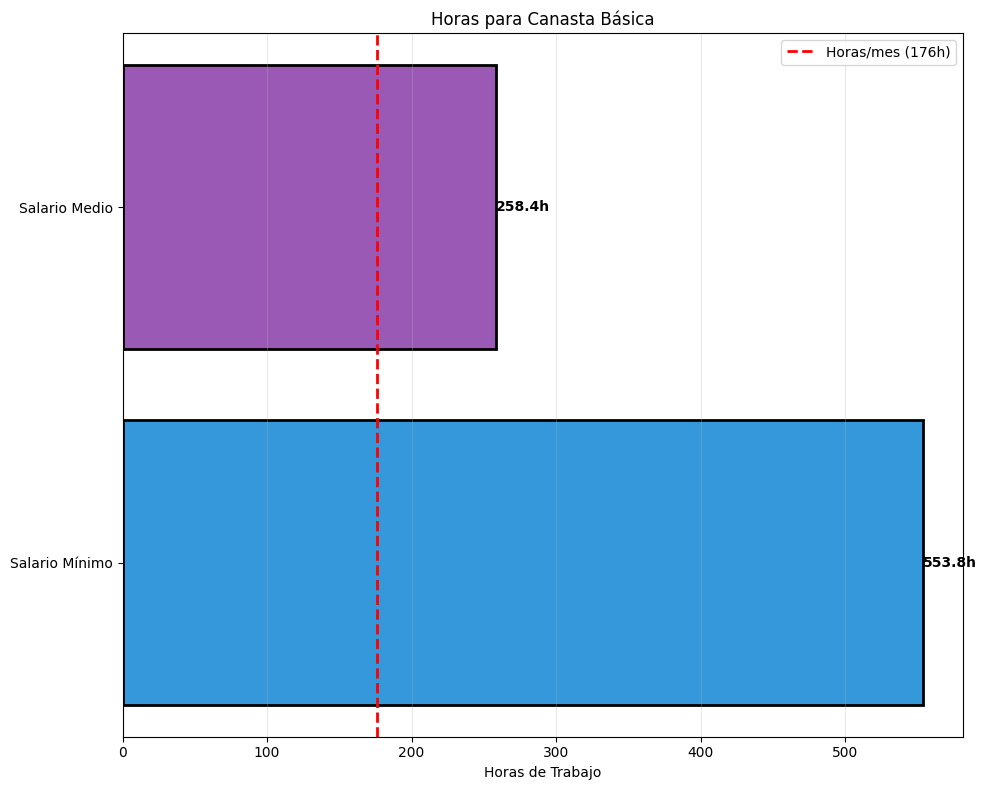

In [ ]:
# Horas de trabajo necesarias para cubrir la cansta basica
fig, ax = plt.subplots(figsize=(10, 8))

precio_hora_minimo = salario_minimo / horas_mes
precio_hora_medio = salario_medio / horas_mes

horas_canasta_minimo = total_canasta_basica / precio_hora_minimo
horas_canasta_medio = total_canasta_basica / precio_hora_medio

horas_mercado_minimo = total_mercado / precio_hora_minimo
horas_mercado_medio = total_mercado / precio_hora_medio

dias_canasta_minimo = horas_canasta_minimo / horas_dia
dias_canasta_medio = horas_canasta_medio / horas_dia
dias_mercado_minimo = horas_mercado_minimo / horas_dia
dias_mercado_medio = horas_mercado_medio / horas_dia


horas_cb = [horas_canasta_minimo, horas_canasta_medio]
labels = ["Salario Mínimo", "Salario Medio"]

bars = ax.barh(labels, horas_cb,
               color=["#3498db", "#9b59b6"],
               edgecolor="black",
               linewidth=2)

ax.axvline(x=horas_mes,
           color="red",
           linestyle="--",
           linewidth=2,
           label=f"Horas/mes ({horas_mes}h)")

ax.set_xlabel("Horas de Trabajo")
ax.set_title("Horas para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}h",
            ha="left",
            va="center",
            fontweight="bold")

plt.tight_layout()
plt.show()


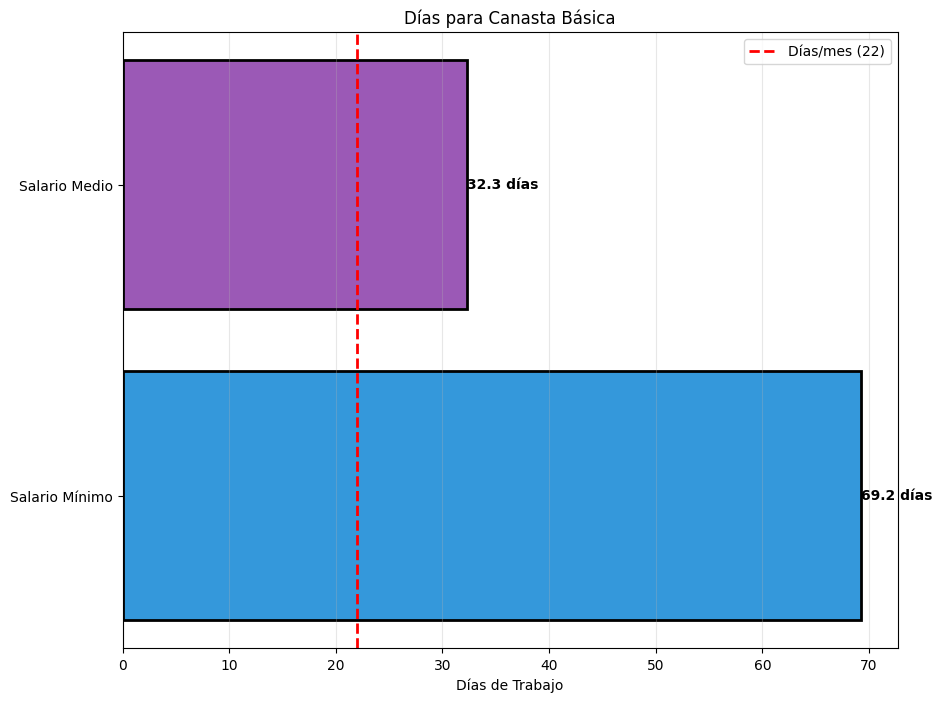

In [ ]:
# días de trabajo necesarios (Canasta Básica)
fig, ax = plt.subplots(figsize=(10, 8))
dias_cb = [dias_canasta_minimo, dias_canasta_medio]
bars = ax.barh(["Salario Mínimo", "Salario Medio"], dias_cb, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.axvline(x=dias_mes, color="red", linestyle="--", linewidth=2, label=f"Días/mes ({dias_mes})")
ax.set_xlabel("Días de Trabajo")
ax.set_title("Días para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
             f"{width:.1f} días", ha="left", va="center", fontweight="bold")


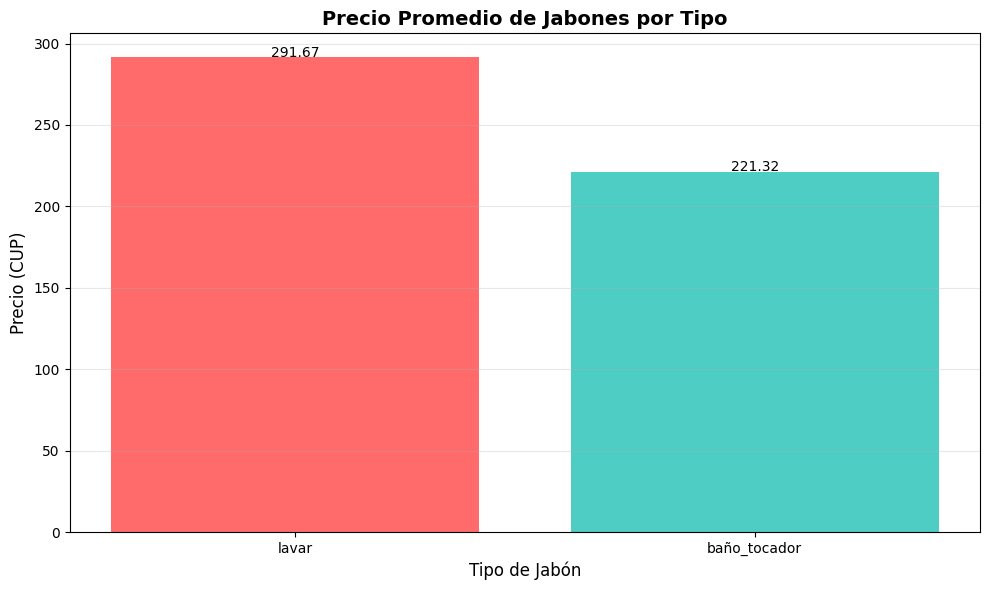

In [ ]:
from modules.graphs import productos_yerro, promedio
from collections import Counter

jabones = []

for element in productos_yerro(yerro_m):
    nombre_lower = element["nombre"].lower()
    if "jabon" in nombre_lower:
        
        if "lavar" in nombre_lower:
            tipo = "lavar"
            
        elif "tocador" in nombre_lower or "baño" in nombre_lower:
            tipo = "baño_tocador"
        
        else:
            tipo = "baño_tocador"
        
        precio = element.get("precio_cup") or element.get("precio cup")
        
        jabones.append({
            "nombre": element["nombre"],
            "tipo": tipo,
            "precio": precio
        })

tipos = [j["tipo"] for j in jabones]
contador_tipos = Counter(tipos)

precios_por_tipo = {}

for jabon in jabones:
    tipo = jabon["tipo"]
    precio = jabon["precio"]
    
    if precio is not None:  
        if tipo not in precios_por_tipo:
            precios_por_tipo[tipo] = []
        precios_por_tipo[tipo].append(precio)

if precios_por_tipo:
    promedios = {}
    for tipo, precios in precios_por_tipo.items():
        if precios:
            promedios[tipo] = promedio(precios)
    
    if promedios:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        
        bars1 = ax1.bar(promedios.keys(), promedios.values(),
                       color=['#FF6B6B', '#4ECDC4', '#FFD166'])
        ax1.set_title('Precio Promedio de Jabones por Tipo', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Precio (CUP)', fontsize=12)
        ax1.set_xlabel('Tipo de Jabón', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')
    
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}', ha='center')
    
        plt.tight_layout()
        plt.show()
        

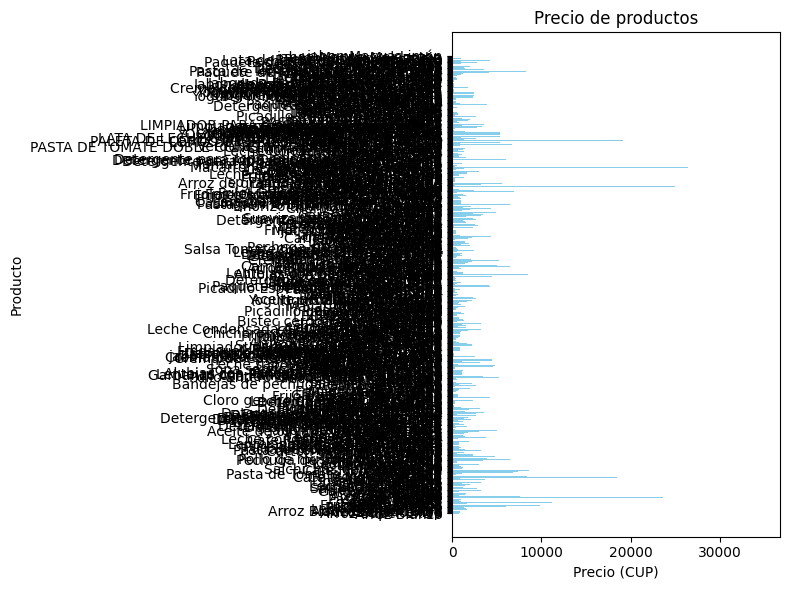

In [ ]:
import matplotlib.pyplot as plt
from modules.graphs import union, productos_yerro, productos_mypimes, cbasica

todo = union(productos_mypimes(mypime), productos_yerro(yerro_m))

def presentacion(todo):
    nombres = []
    precios = []

    for tienda in todo:
        nombre = tienda.get("nombre")
        presentacion_val = tienda.get("presentacion")
        precio = tienda.get("precio_cup")

        if precio is not None and nombre is not None:
            nombres.append(nombre)
            precios.append(precio)

    plt.figure(figsize=(8, 6))
    plt.barh(nombres, precios, color="skyblue")
    plt.xlabel("Precio (CUP)")
    plt.ylabel("Producto")
    plt.title("Precio de productos")
    plt.tight_layout()
    plt.show()

presentacion(todo)


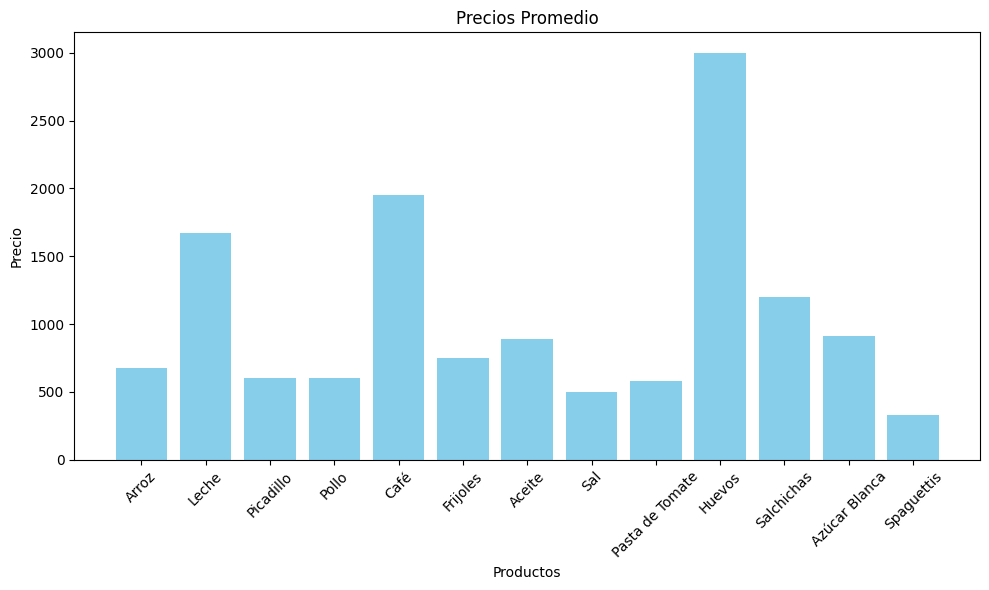

In [ ]:
from modules.graphs import union, canasta_b, promedio

precios_productos = {}                 

for producto in union(mypime, yerro_m):
    for p in producto["productos"]:
        for cb in canasta_b(canasta_basica):
            if cb["nombre"].lower() in p["nombre"].lower():
                nombre = cb["nombre"]
                precio = p["precio_cup"]        
                if nombre not in precios_productos: 
                    precios_productos[nombre] = []
                    precios_productos[nombre].append(precio)

promedios = {}
for nombre, precios in precios_productos.items():
    if precios:
        promedios[nombre] = promedio(precios)

plt.figure(figsize=(10, 6))
plt.bar(promedios.keys(), promedios.values(), color='skyblue')
plt.title("Precios Promedio")
plt.xlabel("Productos")
plt.ylabel("Precio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()                   
    

El costo de la canasta básica representa una proporción crítica del ingreso mensual.

Esto indica que el salario promedio no permite cubrir necesidades básicas sin comprometer prácticamente todo el ingreso.


## Síntesis del análisis

A lo largo del análisis se repite un patrón consistente:
precios altos, variabilidad entre mercados y una débil relación con el ingreso.

No se trata de productos aislados ni de mercados específicos, sino de un comportamiento estructural.


## Conclusiones

Los resultados del análisis muestran una desconexión estructural entre el salario promedio y los precios de los productos básicos en las MiPymes.

El mercado no utiliza el salario como referencia para la formación de precios. Como consecuencia, el ingreso mensual del trabajador no garantiza el acceso estable a bienes esenciales, sino que obliga a priorizar, renunciar y postergar consumo.

Cuando productos cotidianos requieren una fracción significativa del salario o varios días de trabajo, el problema deja de ser individual y se vuelve sistémico.

Este análisis no demuestra que los precios sean altos en términos absolutos, sino que son incompatibles con el nivel de ingreso existente. Mientras esa relación no se restablezca, el trabajo perderá su función como mecanismo de acceso al consumo básico.

